In [10]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from astropy.modeling import models, fitting
import astropy.modeling.fitting as af
%config InlineBackend.figure_format = 'retina'
from scipy.ndimage import gaussian_filter1d
from scipy import signal
from scipy.signal import medfilt
from scipy.interpolate import UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import matplotlib
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import glob, os

In [11]:
hdul = fits.open('data/smc_snr/blah4.fits')
flux = hdul[0].data
hdr = hdul[0].header

if 'CD1_1' in hdr:
    wave = hdr['CRVAL1'] + hdr['CD1_1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)
else:
    wave = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)

### Gaussian fitting function

In [ ]:
def gaussfit(data, fittername = 'TRFLSQFitter', plot=True):
    data = np.asarray(data, dtype=np.float64)
    smooth = signal.savgol_filter(data, window_length=9, polyorder=2)

    cont_mask = data < np.percentile(data, 70)
    cont = np.median(data[cont_mask])
    # noise = np.std(data[cont_mask])

    p16, p84 = np.percentile(data, [16, 84])
    noise = (p84 - p16) / 2 

    height = cont + 4 * noise 
    prom  = 2 * noise
    
    peaks, _ = find_peaks(smooth, height=height, prominence=prom, distance = 5)

    gauss = []
    for p in peaks:
        g = models.Gaussian1D(amplitude=data[p], mean=wave[p], stddev = None)
        # g.stddev.min = 0.1
        # g.stddev.max = 10.0

        gauss.append(g)

    total = np.sum(gauss)
    fitter = getattr(af, fittername)()
    fitted_model = fitter(total, wave, data)     

    residuals = data - fitted_model(wave)
    chi_squared = np.sum((residuals / noise) ** 2)
    dof = len(data) - len(gauss) * 3
    reduced_chi_squared = chi_squared / dof
    # print(f'Reduced Chi-Squared: {reduced_chi_squared:.2f}')
    # print(f'Number of Gaussians: {len(gauss)}')
   
    if plot==True:
        plt.figure(figsize = (7.1, 3.5), dpi = 200)
        plt.plot(wave,data,lw=0.75, label=r'$\mathrm{Spectrum}$')

        plt.plot(wave,fitted_model(wave),lw=0.75, label=r'$\mathrm{Multi\ Gaussian\ Fit}$', color = 'red', ls='dashed')
        for g in gauss:
            plt.plot(wave, g(wave), lw = 0.5)
        plt.legend() 
    return fitted_model, len(gauss), reduced_chi_squared

### Comparing different fitters

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11657103.461791545
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11657103.461791545
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]


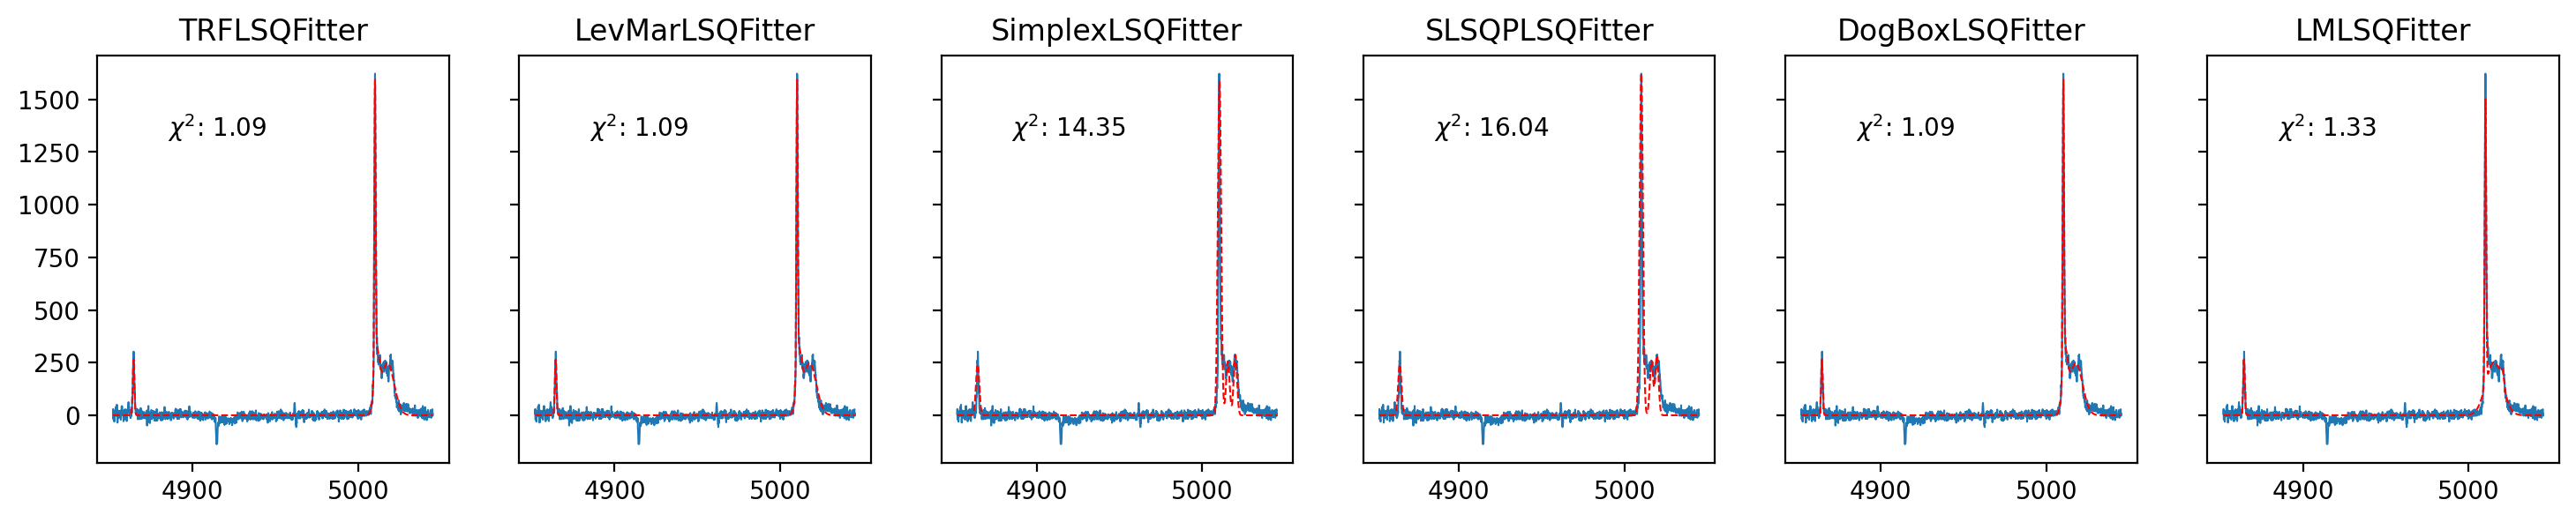

In [44]:
fitters= ['TRFLSQFitter', 'LevMarLSQFitter', 'SimplexLSQFitter', 'SLSQPLSQFitter', 'DogBoxLSQFitter', 'LMLSQFitter']

fit, ax = plt.subplots(1, len(fitters), figsize = (len(fitters)*3, 3), sharey = True)

idx = 200

for i, fit in enumerate(fitters):    
    ax[i].plot(wave, flux[idx], lw=0.75, label=r'$\mathrm{Spectrum}$')
    ax[i].plot(wave, gaussfit(flux[idx], fittername=fit, plot=False)[0](wave), lw=0.75, label=r'$\mathrm{Multi\ Gaussian\ Fit}$', color = 'red', ls='dashed')
    ax[i].set_title(fit)
    ax[i].text(0.2, 0.8, f'$\chi^2$: {gaussfit(flux[idx], fittername=fit, plot=False)[2]:.2f}', transform=ax[i].transAxes)

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12), dpi=200)
axes = axes.flatten()

indice = list(range(60, 80))

for i in indice:
    axes[i - min(indice)].plot(wave, flux[i], lw = 0.5)
    axes[i - min(indice)].plot(wave, gaussfit(flux[i], plot=False)[0](wave), lw=0.75, ls='dashed', color = 'red')
    axes[i - min(indice)].text(0.05, 0.9, f'Gaussians: {gaussfit(flux[i], plot=False)[1]}\nReduced Chi²: {gaussfit(flux[i], plot=False)[2]:.2f}', transform=axes[i - min(indice)].transAxes, fontsize=8,
                 verticalalignment='top')
    axes[i - min(indice)].set_title(f'{i}')

plt.tight_layout()